List down global market indices: 
Nifty 50, Dow Jones Index, Nasdaq, Hang Seng, Nikkei 225, Dax

- Check symbols for each of the index above which will help you to fetch data 
- Check R/Python syntax to download data for each index for Six years.(from 1st Jan 2018 till 31st December 2023-OHLC Data)
- Add USA VIX data for Six years (Volatility Index- Fear Factor)
- Calculate daily returns based on close prices of each index: ( Yt-Yt-1)/(Yt-1)  * 100
- Check if daily returns follow Normal distribution
- Rename variables in each file (Example: Nifty50_Open,Nifty50_Adjclose)
- Merge all the above files with outer join (note that holidays are different globally)
- Impute missing data using LOCF method
- Create indicator variable for “Quarter”
- Create indicator variable for “Month”
- Create indicator variable for “Year”
- Finalize Master Data which will be used for Phase 2


In [6]:
import yfinance as yf
import pandas as pd
import numpy as np

# Define tickers and friendly names
tickers = {
    "^NSEI": "Nifty",
    "^DJI": "DowJones",
    "^IXIC": "Nasdaq",
    "^HSI": "HangSeng",
    "^N225": "Nikkei",
    "^GDAXI": "DAX",
    "^VIX": "VIX"
}

In [7]:
start_date = "2019-01-01"
end_date = "2025-04-30"

# Download and keep only Open and Close
data_frames = {}
for ticker, name in tickers.items():
    data = yf.download(ticker, start=start_date, end=end_date)[['Open', 'Close']]
    data.columns = [f"{name}_Open", f"{name}_Close"]
    data_frames[name] = data

# Get full date range including all days (weekends and holidays included)
full_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Reindex each DataFrame to this full range and interpolate missing Open/Close
for name, df in data_frames.items():
    df = df.reindex(full_range)  # this introduces NaNs for missing dates
    df[f"{name}_Open"] = df[f"{name}_Open"].interpolate(method='linear', limit_direction='both')
    df[f"{name}_Close"] = df[f"{name}_Close"].interpolate(method='linear', limit_direction='both')
    data_frames[name] = df

# Merge all into one master table
master_table = pd.concat(data_frames.values(), axis=1)

# Optional: Reset index and rename
master_table.index.name = "Date"
master_table.reset_index(inplace=True)

print(master_table.head())

master_table.to_csv("markets.csv", index=False)

/var/folders/y3/0yphlgnn3szgcjyr68zc1w680000gn/T/ipykernel_76515/3673606301.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)[['Open', 'Close']]
[*********************100%***********************]  1 of 1 completed
/var/folders/y3/0yphlgnn3szgcjyr68zc1w680000gn/T/ipykernel_76515/3673606301.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)[['Open', 'Close']]
[*********************100%***********************]  1 of 1 completed
/var/folders/y3/0yphlgnn3szgcjyr68zc1w680000gn/T/ipykernel_76515/3673606301.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)[['Open', 'Close']]
[*********************100%***********************]  1 of 1 completed
/var/folders/y3/0yphlgnn3szgcjyr68zc1w680000gn/T/ipykernel_76515/36736063

        Date    Nifty_Open   Nifty_Close  DowJones_Open  DowJones_Close  \
0 2019-01-01  10868.849609  10792.500000   23058.609375    23346.240234   
1 2019-01-02  10868.849609  10792.500000   23058.609375    23346.240234   
2 2019-01-03  10796.799805  10672.250000   23176.390625    22686.220703   
3 2019-01-04  10699.700195  10727.349609   22894.919922    23433.160156   
4 2019-01-05  10734.750000  10742.166341   23088.033203    23465.889974   

   Nasdaq_Open  Nasdaq_Close  HangSeng_Open  HangSeng_Close   Nikkei_Open  \
0  6506.910156   6665.939941   25824.439453    25130.349609  19655.130859   
1  6506.910156   6665.939941   25824.439453    25130.349609  19655.130859   
2  6584.770020   6463.500000   25077.679688    25064.359375  19655.130859   
3  6567.140137   6738.859863   24946.119141    25626.029297  19655.130859   
4  6630.603353   6767.063314   25302.692708    25695.919271  19751.623698   

   Nikkei_Close      DAX_Open     DAX_Close   VIX_Open  VIX_Close  
0  19561.960938  1

In [20]:
markets = pd.read_csv("markets.csv")
markets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2312 entries, 0 to 2311
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            2312 non-null   object 
 1   Nifty_Open      2312 non-null   float64
 2   Nifty_Close     2312 non-null   float64
 3   DowJones_Open   2312 non-null   float64
 4   DowJones_Close  2312 non-null   float64
 5   Nasdaq_Open     2312 non-null   float64
 6   Nasdaq_Close    2312 non-null   float64
 7   HangSeng_Open   2312 non-null   float64
 8   HangSeng_Close  2312 non-null   float64
 9   Nikkei_Open     2312 non-null   float64
 10  Nikkei_Close    2312 non-null   float64
 11  DAX_Open        2312 non-null   float64
 12  DAX_Close       2312 non-null   float64
 13  VIX_Open        2312 non-null   float64
 14  VIX_Close       2312 non-null   float64
dtypes: float64(14), object(1)
memory usage: 271.1+ KB


In [21]:
# Calculate the daily return based on the closing price
for ticker in tickers.values():
    markets[f"{ticker}_Return"] = (markets[f"{ticker}_Close"] - markets[f"{ticker}_Open"]) / markets[f"{ticker}_Open"] * 100

markets.head()

,Date,Nifty_Open,Nifty_Close,DowJones_Open,DowJones_Close,Nasdaq_Open,Nasdaq_Close,HangSeng_Open,HangSeng_Close,Nikkei_Open,...,DAX_Close,VIX_Open,VIX_Close,Nifty_Return,DowJones_Return,Nasdaq_Return,HangSeng_Return,Nikkei_Return,DAX_Return,VIX_Return
0,2019-01-01,10868.849609,10792.500000,23058.609375,23346.240234,6506.910156,6665.939941,25824.439453,25130.349609,19655.130859,...,10580.190430,27.540001,23.219999,-0.702463,1.247390,2.444014,-2.687725,-0.474023,0.977507,-15.686280
1,2019-01-02,10868.849609,10792.500000,23058.609375,23346.240234,6506.910156,6665.939941,25824.439453,25130.349609,19655.130859,...,10580.190430,27.540001,23.219999,-0.702463,1.247390,2.444014,-2.687725,-0.474023,0.977507,-15.686280
2,2019-01-03,10796.799805,10672.250000,23176.390625,22686.220703,6584.770020,6463.500000,25077.679688,25064.359375,19655.130859,...,10416.660156,25.680000,25.450001,-1.153581,-2.114954,-1.841674,-0.053116,-0.474023,-0.481988,-0.895637
3,2019-01-04,10699.700195,10727.349609,22894.919922,23433.160156,6567.140137,6738.859863,24946.119141,25626.029297,19655.130859,...,10767.690430,24.360001,21.379999,0.258413,2.350916,2.614833,2.725515,-0.474023,2.219018,-12.233175
4,2019-01-05,10734.750000,10742.166341,23088.033203,23465.889974,6630.603353,6767.063314,25302.692708,25695.919271,19751.623698,...,10761.063477,23.593334,21.386666,0.069087,1.636591,2.058032,1.554090,-0.155225,1.257501,-9.352928


In [22]:
# Check for normality of the returns
from scipy.stats import shapiro

# SJapiro-Wilk test for normality
for ticker in tickers.values():
    stat, p = shapiro(markets[f"{ticker}_Return"])
    print(f"Shapiro-Wilk Test for {ticker}_Return: Statistics={stat}, p-value={p}")
    if p > 0.05:
        print(f"{ticker}_Return follows a normal distribution (fail to reject H0)")
    else:
        print(f"{ticker}_Return does not follow a normal distribution (reject H0)")


# Lilliefors test for normality
from statsmodels.stats.diagnostic import lilliefors

for ticker in tickers.values():
    stat, p = lilliefors(markets[f"{ticker}_Return"])
    print(f"Lilliefors Test for {ticker}_Return: Statistics={stat}, p-value={p}")
    if p > 0.05:
        print(f"{ticker}_Return follows a normal distribution (fail to reject H0)")
    else:
        print(f"{ticker}_Return does not follow a normal distribution (reject H0)")

# Normality tests results returned by both Shapiro-Wilk and Lilliefors
# tests indicate whether the returns of each market index follow a normal distribution or not.
# Nevertheless, we will use a qq plot to visually assess the normality of the returns.

Shapiro-Wilk Test for Nifty_Return: Statistics=0.8879446131750753, p-value=4.882026146955002e-38
Nifty_Return does not follow a normal distribution (reject H0)
Shapiro-Wilk Test for DowJones_Return: Statistics=0.9101363440274829, p-value=6.107023512089685e-35
DowJones_Return does not follow a normal distribution (reject H0)
Shapiro-Wilk Test for Nasdaq_Return: Statistics=0.940396673682592, p-value=1.5212223120124294e-29
Nasdaq_Return does not follow a normal distribution (reject H0)
Shapiro-Wilk Test for HangSeng_Return: Statistics=0.9619526658210166, p-value=3.453908828924627e-24
HangSeng_Return does not follow a normal distribution (reject H0)
Shapiro-Wilk Test for Nikkei_Return: Statistics=0.8542049728936724, p-value=6.531564461454799e-42
Nikkei_Return does not follow a normal distribution (reject H0)
Shapiro-Wilk Test for DAX_Return: Statistics=0.9345908823699851, p-value=1.0049730686119735e-30
DAX_Return does not follow a normal distribution (reject H0)
Shapiro-Wilk Test for VIX_R

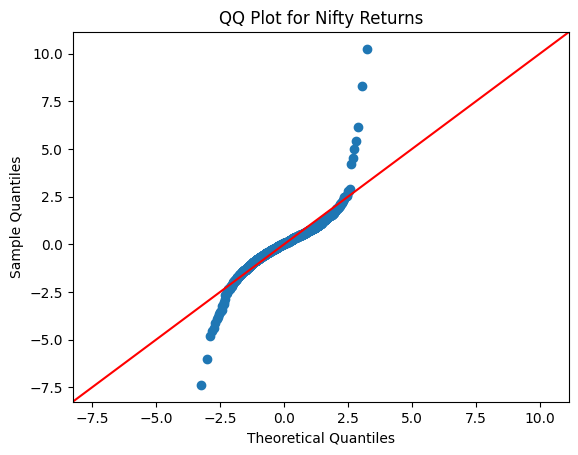

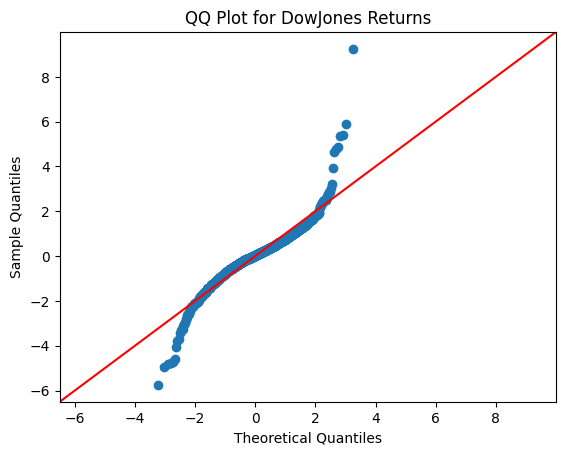

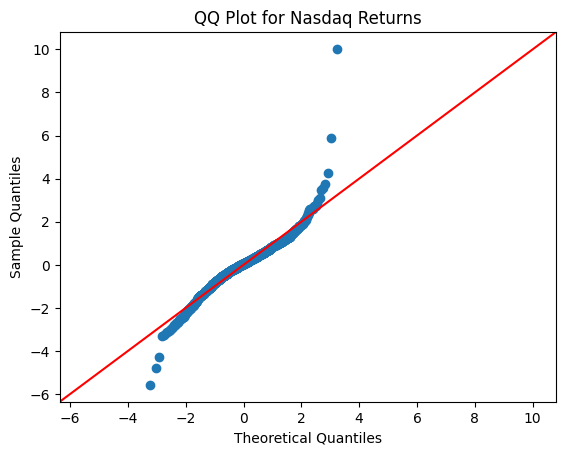

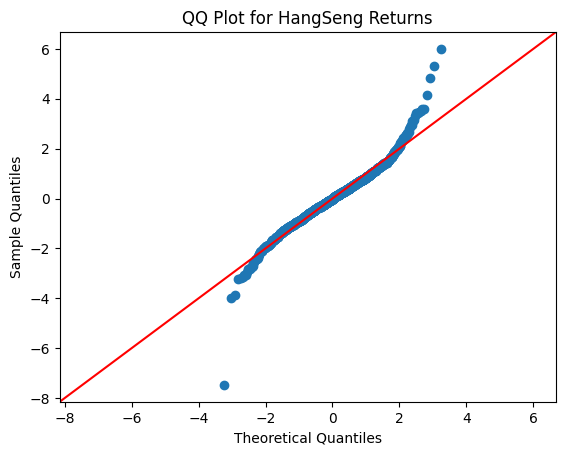

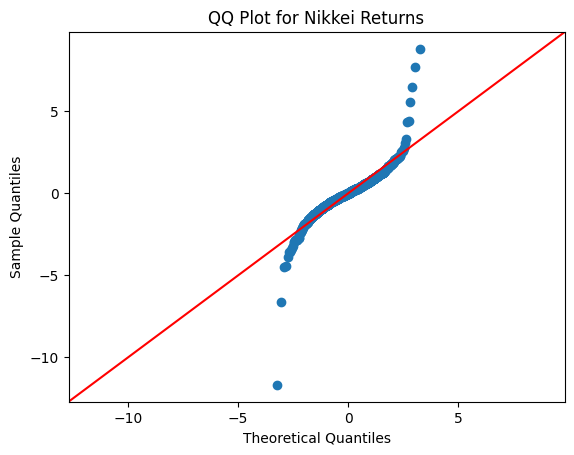

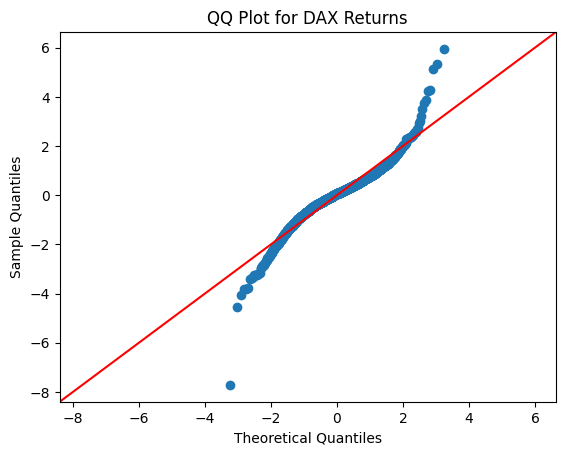

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

for ticker in tickers.values():
    if ticker != "VIX":
        sm.graphics.qqplot(markets[f"{ticker}_Return"], line='45', fit=True)
        plt.title(f"QQ Plot for {ticker} Returns")
        plt.show()

In [24]:
markets["Quarter"] = pd.to_datetime(markets["Date"]).dt.quarter
markets["Month"] = pd.to_datetime(markets["Date"]).dt.month
markets["Year"] = pd.to_datetime(markets["Date"]).dt.year
markets["dayofweek"] = pd.to_datetime(markets["Date"]).dt.dayofweek
markets["day"] = pd.to_datetime(markets["Date"]).dt.day

# Remove weekends from the dataset
markets = markets[markets.dayofweek < 5]
# Remove the first of Jan of each year
markets = markets[~((markets["Month"] == 1) & (markets["day"] == 1))]

markets.drop(columns=["dayofweek", "day"], inplace=True)
markets.reset_index(inplace=True, drop=True, names="Date")

print(markets.info())

markets.to_csv("markets_with_returns.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1647 entries, 0 to 1646
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             1647 non-null   object 
 1   Nifty_Open       1647 non-null   float64
 2   Nifty_Close      1647 non-null   float64
 3   DowJones_Open    1647 non-null   float64
 4   DowJones_Close   1647 non-null   float64
 5   Nasdaq_Open      1647 non-null   float64
 6   Nasdaq_Close     1647 non-null   float64
 7   HangSeng_Open    1647 non-null   float64
 8   HangSeng_Close   1647 non-null   float64
 9   Nikkei_Open      1647 non-null   float64
 10  Nikkei_Close     1647 non-null   float64
 11  DAX_Open         1647 non-null   float64
 12  DAX_Close        1647 non-null   float64
 13  VIX_Open         1647 non-null   float64
 14  VIX_Close        1647 non-null   float64
 15  Nifty_Return     1647 non-null   float64
 16  DowJones_Return  1647 non-null   float64
 17  Nasdaq_Return 